In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/AbnerHqC/GaitSet.git

Cloning into 'GaitSet'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 106 (delta 29), reused 22 (delta 22), pack-reused 62 (from 1)
Receiving objects: 100% (106/106), 54.42 MiB | 29.05 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
!unzip "/content/drive/MyDrive/preprocessed.zip" -d /content/GaitSet/

Streaming output truncated to the last 5000 lines.
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-062.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-063.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-064.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-065.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-066.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-067.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-068.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-069.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-070.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-071.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-072.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/1

In [ ]:
cd GaitSet

/content/GaitSet


In [ ]:
!python train.py

Initialzing...
Initializing data source...
Loading training data...
Data initialization complete.
Initializing model...
Model initialization complete.
Training START
iter 100:, hard_loss_metric=0.43674657, full_loss_metric=0.19344778, full_loss_num=186641.45312500, mean_dist=0.19000679, lr=0.000100, hard or full='full'
iter 200:, hard_loss_metric=0.52632153, full_loss_metric=0.18823411, full_loss_num=129312.50000000, mean_dist=0.41774544, lr=0.000100, hard or full='full'
iter 300:, hard_loss_metric=0.54481298, full_loss_metric=0.18795681, full_loss_num=100565.46093750, mean_dist=0.56247151, lr=0.000100, hard or full='full'
iter 400:, hard_loss_metric=0.54565513, full_loss_metric=0.18675646, full_loss_num=89372.17187500, mean_dist=0.63735288, lr=0.000100, hard or full='full'
iter 500:, hard_loss_metric=0.55011010, full_loss_metric=0.18606248, full_loss_num=78800.40625000, mean_dist=0.71359807, lr=0.000100, hard or full='full'
iter 600:, hard_loss_metric=0.54962224, full_loss_metric=0.18

In [ ]:
from model.network.gaitset import SetNet
import torch.optim as optim
import torch.nn as nn
import torch
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

In [ ]:
encoder = SetNet(256)
encoder = nn.DataParallel(encoder)
encoder.cuda()

model_name = 'GaitSet'
encoder.load_state_dict(torch.load('/content/GaitSet/work/checkpoint/GaitSet/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-10000-encoder.ptm'))

<All keys matched successfully>

In [ ]:
encoder.eval()

from model.initialization import initialize_data
from config import conf

train_source, test_source = initialize_data(conf, train = False, test = True)

Initializing data source...
Loading test data...
Data initialization complete.


In [ ]:
from copy import deepcopy
import numpy as np

# train_source, test_source = initialize_data(conf, train = False, test = False)
data_config = conf['data']
model_config = conf['model']
model_param = deepcopy(model_config)
model_param['train_source'] = None
model_param['test_source'] = test_source
model_param['train_pid_num'] = data_config['pid_num']
batch_size = int(np.prod(model_config['batch_size']))
model_param['save_name'] = '_'.join(map(str,[
    model_config['model_name'],
    data_config['dataset'],
    data_config['pid_num'],
    data_config['pid_shuffle'],
    model_config['hidden_dim'],
    model_config['margin'],
    batch_size,
    model_config['hard_or_full_trip'],
    model_config['frame_num'],
]))
restore_iter = 80000

In [ ]:
import torch.utils.data as tordata
from model.model import Model

model = Model(**model_param)
data_loader = tordata.DataLoader(
            dataset=test_source,
            batch_size=1,
            sampler=tordata.sampler.SequentialSampler(test_source),
            collate_fn=model.collate_fn,
            num_workers=2)

In [ ]:
data_loader

In [ ]:
feature_list = list()
view_list = list()
seq_type_list = list()
label_list = list()

In [ ]:
for i, data in enumerate(data_loader):
    seq, view, seq_type, label, batch_frame = data

    seq[0] = model.np2var(seq[0])
    batch_frame = model.np2var(batch_frame)

    feature, _ = encoder(*seq, batch_frame)
    feature_list.append(feature.view(1, -1).data.cpu().numpy())
    view_list += view
    seq_type_list += seq_type
    label_list += label

In [ ]:
data = np.concatenate(feature_list, 0), view_list, seq_type_list, label_list
feature, view, seq_type, label = data
label = np.array(label)
view_list = list(set(view))
view_list.sort()
view_num = len(view_list)
sample_num = len(feature)

In [ ]:
feature.shape

(5485, 15872)

In [ ]:
probe_seq_dict =  [['nm-05', 'nm-06'], ['bg-01', 'bg-02'], ['cl-01', 'cl-02']]
gallery_seq_dict = [['nm-01', 'nm-02', 'nm-03', 'nm-04']]

In [ ]:
def euclid_dist(a, b):
    a2 = np.sum(a**2, axis=1, keepdims=True)
    b2 = np.sum(b**2, axis=1, keepdims=True)
    dist = a2 + b2.T - 2 * a @ b.T
    dist = np.sqrt(np.maximum(0, dist))
    return dist


In [ ]:
acc_nm = []
acc_cl = []
acc_bg = []

In [ ]:
encoder = SetNet(256)
encoder = nn.DataParallel(encoder)
encoder.cuda()

for i in range(1000, 10001, 1000):
    filename = f"/content/GaitSet/work/checkpoint/GaitSet/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-{str(i).zfill(5)}-encoder.ptm"
    encoder.load_state_dict(torch.load(filename))

    model_name = 'GaitSet'
    encoder.load_state_dict(torch.load(filename))

    feature_list = list()
    view_list = list()
    seq_type_list = list()
    label_list = list()

    for i, data in enumerate(data_loader):
        seq, view, seq_type, label, batch_frame = data

        seq[0] = model.np2var(seq[0])
        batch_frame = model.np2var(batch_frame)

        feature, _ = encoder(*seq, batch_frame)
        feature_list.append(feature.view(1, -1).data.cpu().numpy())
        view_list += view
        seq_type_list += seq_type
        label_list += label

    data = np.concatenate(feature_list, 0), view_list, seq_type_list, label_list
    feature, view, seq_type, label = data
    label = np.array(label)
    view_list = list(set(view))
    view_list.sort()
    view_num = len(view_list)
    sample_num = len(feature)

    acc = np.zeros([len(probe_seq_dict), view_num, view_num])
    for (p, probe_seq) in enumerate(probe_seq_dict):
        for gallery_seq in gallery_seq_dict:
            for (v1, probe_view) in enumerate(view_list):
                for (v2, gallery_view) in enumerate(view_list):
                    gseq_mask = np.isin(view, gallery_view) & np.isin(seq_type, gallery_seq)
                    pseq_mask = np.isin(view, probe_view) & np.isin(seq_type, probe_seq)

                    gseq = feature[gseq_mask]  # 200, (62 x 256)
                    pseq = feature[pseq_mask]   # 100, (62 x 256)

                    dist = euclid_dist(pseq, gseq) # 100, 200
                    idx = np.argmin(dist, axis=1)  # 100

                    gseq_label = label[gseq_mask]  # 200,
                    pseq_label = label[pseq_mask]  # 100,
                    # print(idx)
                    # print(np.sum(gseq_label[idx] == pseq_label) * 100 / 16)
                    acc[p, v1, v2] = np.sum(gseq_label[idx] == pseq_label) * 100 / 100

    acc_nm.append(np.sum(acc[0]) / 121)
    acc_cl.append(np.sum(acc[1]) / 121)
    acc_bg.append(np.sum(acc[2]) / 121)

In [ ]:
acc_nm, acc_cl, acc_bg

([np.float64(84.3305785123967),
  np.float64(89.10743801652893),
  np.float64(91.31404958677686),
  np.float64(91.74380165289256),
  np.float64(91.97520661157024),
  np.float64(93.11570247933884),
  np.float64(92.97520661157024),
  np.float64(93.39669421487604),
  np.float64(93.96694214876032),
  np.float64(93.73553719008264)],
 [np.float64(69.98347107438016),
  np.float64(76.4297520661157),
  np.float64(80.09917355371901),
  np.float64(81.7107438016529),
  np.float64(82.2396694214876),
  np.float64(84.12396694214875),
  np.float64(84.24793388429752),
  np.float64(84.78512396694215),
  np.float64(85.78512396694215),
  np.float64(85.98347107438016)],
 [np.float64(46.743801652892564),
  np.float64(56.34710743801653),
  np.float64(59.388429752066116),
  np.float64(63.247933884297524),
  np.float64(64.84297520661157),
  np.float64(65.69421487603306),
  np.float64(67.28099173553719),
  np.float64(66.38842975206612),
  np.float64(66.75206611570248),
  np.float64(68.1900826446281)])

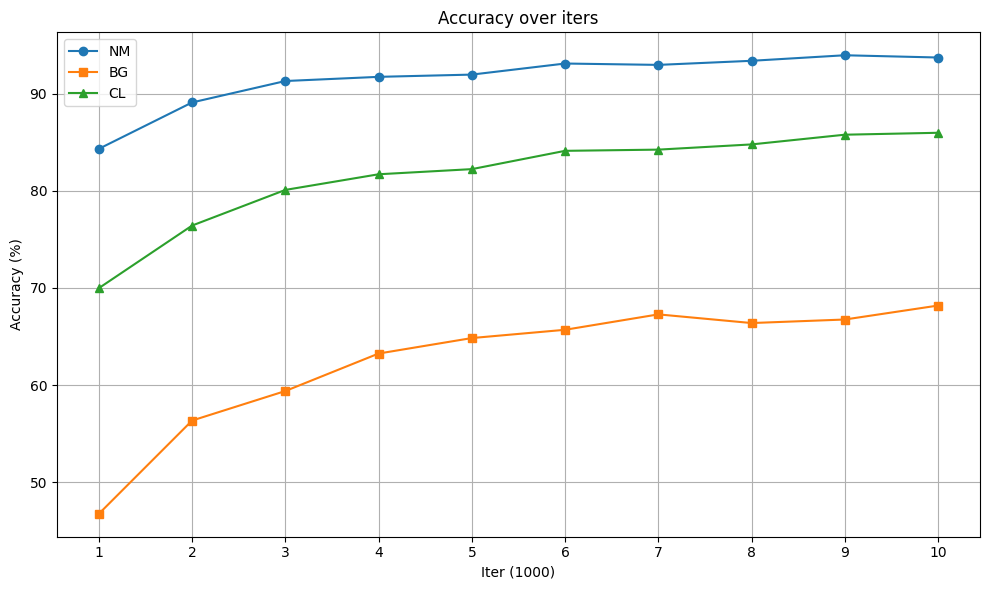

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1, 11)  # X-axis: 1 to 10

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, acc_nm, marker='o', label='NM')
plt.plot(x, acc_bg, marker='s', label='BG')
plt.plot(x, acc_cl, marker='^', label='CL')

plt.title('Accuracy over iters')
plt.xlabel('Iter (1000)')
plt.ylabel('Accuracy (%)')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from model.network.gaitset_noglobal import SetNet

In [ ]:
acc_nm_ngl = []
acc_cl_ngl = []
acc_bg_ngl = []

encoder = SetNet(256)
encoder = nn.DataParallel(encoder)
encoder.cuda()

for i in range(1000, 10001, 1000):  # From 1000 to 10000, inclusive
    filename = f"/content/GaitSet/work/checkpoint/GaitSet_NoGL/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-{str(i).zfill(5)}-encoder.ptm"
    encoder.load_state_dict(torch.load(filename))

    model_name = 'GaitSet'
    encoder.load_state_dict(torch.load(filename))

    feature_list = list()
    view_list = list()
    seq_type_list = list()
    label_list = list()

    for i, data in enumerate(data_loader):
        seq, view, seq_type, label, batch_frame = data

        seq[0] = model.np2var(seq[0])
        batch_frame = model.np2var(batch_frame)

        feature, _ = encoder(*seq, batch_frame)
        feature_list.append(feature.view(1, -1).data.cpu().numpy())
        view_list += view
        seq_type_list += seq_type
        label_list += label

    data = np.concatenate(feature_list, 0), view_list, seq_type_list, label_list
    feature, view, seq_type, label = data
    label = np.array(label)
    view_list = list(set(view))
    view_list.sort()
    view_num = len(view_list)
    sample_num = len(feature)

    acc = np.zeros([len(probe_seq_dict), view_num, view_num])
    for (p, probe_seq) in enumerate(probe_seq_dict):
        for gallery_seq in gallery_seq_dict:
            for (v1, probe_view) in enumerate(view_list):
                for (v2, gallery_view) in enumerate(view_list):
                    gseq_mask = np.isin(view, gallery_view) & np.isin(seq_type, gallery_seq)
                    pseq_mask = np.isin(view, probe_view) & np.isin(seq_type, probe_seq)

                    gseq = feature[gseq_mask]  # 200, (62 x 256)
                    pseq = feature[pseq_mask]   # 100, (62 x 256)

                    dist = euclid_dist(pseq, gseq) # 100, 200
                    idx = np.argmin(dist, axis=1)  # 100

                    gseq_label = label[gseq_mask]  # 200,
                    pseq_label = label[pseq_mask]  # 100,
                    # print(idx)
                    # print(np.sum(gseq_label[idx] == pseq_label) * 100 / 16)
                    acc[p, v1, v2] = np.sum(gseq_label[idx] == pseq_label) * 100 / 100

    acc_nm_ngl.append(np.sum(acc[0]) / 121)
    acc_cl_ngl.append(np.sum(acc[1]) / 121)
    acc_bg_ngl.append(np.sum(acc[2]) / 121)

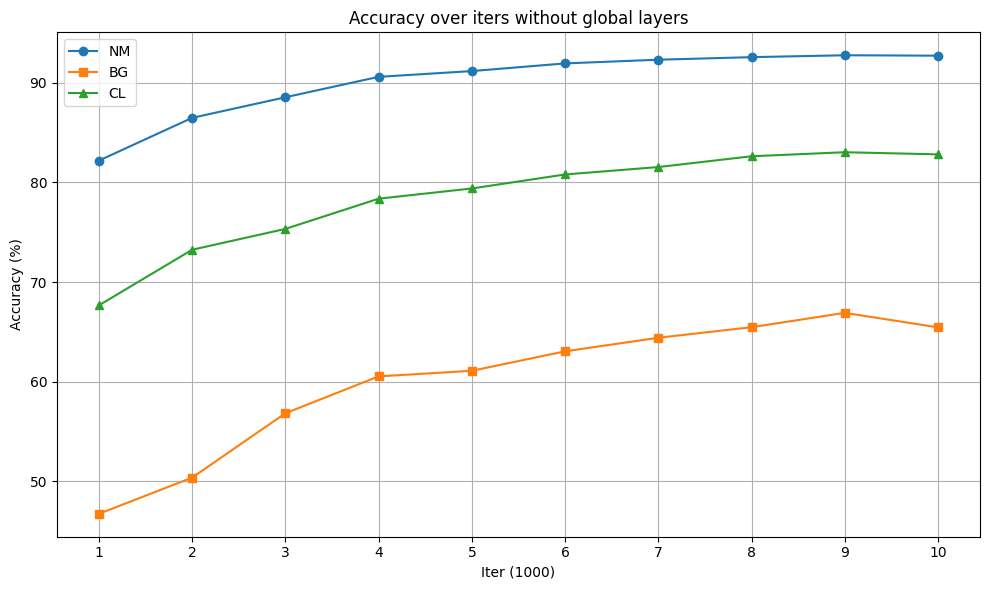

In [ ]:
x = np.arange(1, 11)  # X-axis: 1 to 10

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, acc_nm_ngl, marker='o', label='NM')
plt.plot(x, acc_bg_ngl, marker='s', label='BG')
plt.plot(x, acc_cl_ngl, marker='^', label='CL')

plt.title('Accuracy over iters without global layers')
plt.xlabel('Iter (1000)')
plt.ylabel('Accuracy (%)')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()